In [1]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
from mdp import *
from utils import *
import pdb
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Infinite Horizon Planning (LAO*)

In this PSET, you'll get to implement LAO-star. Here are a few resources that may help:
- [LAO-star Paper](http://rbr.cs.umass.edu/papers/HZaij01b.pdf)
- [AIMA](http://aima.cs.berkeley.edu/)
- [University of Waterloo Slides](https://cs.uwaterloo.ca/~ppoupart/teaching/cs886-spring13/slides/cs886-module9-lao-star.pdf)
- [University of Washington, Seattle Slides](http://research.microsoft.com/en-us/um/people/akolobov/MDPs_Tutorial.pdf)

## Introduction

LAO* is a very useful way to solve problems that can be posed as Markov Decision Processes. This is especially relevant when the autonomous agent has stochastic dynamics. In this PSET we consider a quadcopter that flies around in a gridworld. However, due to complex wind models, each commanded action has some probability of moving the quadcopter in an unintended direction. 

We'll be using some Python classes provided by the Articifical Intelligence: A Modern Approach text by Russel and Norvig. Now would be a good time to glance over the two files, `mdp.py` and `grid_mdp.py` to see the functionality that is provided. Run the the following cell to read in an `.mdp` file and visualize the world. The problem is also drawn from the AIMA textbook (Figure 17), and modified in various ways throughout this PSET. 

States= 11 Actions= 4 Terminals 2


/home/steve/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


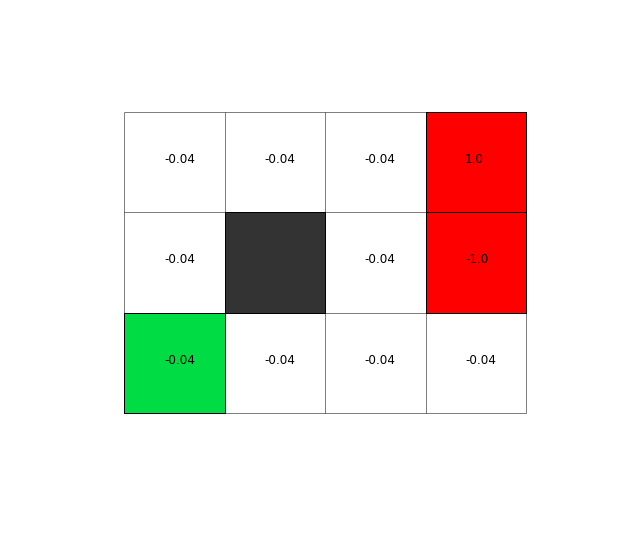

In [2]:
# Visualizing an example graph/grid world
mdp = read_mdp("fig17.mdp")
grid = mdp.to_grid()
grid.draw()

As you can see, this MDP problem has 11 states, 4 actions, and 2 terminal states. The shortest-path problem involves going from the green cell (0,0) to the terminal cells (3,2). The other terminal cell (3,1) could be thought of as an obstacle -- going into this cell is an unrecoverable crash. The values in each cell indicate the immediate reward at that cell. There are some other useful properties that you can use as well, demonstrated in the next cell. 

In [3]:
print "Action list:", mdp.actlist
print "Transition probabilities from (0,1)" 
for (result_state, prob) in mdp.T('(0,1)', '(0,1)').iteritems():
    print "Probability quad will land in state: ", result_state, " is ", prob

Action list: ['(0,1)', '(0,-1)', '(1,0)', '(-1,0)']
Transition probabilities from (0,1)
Probability quad will land in state:  (0,1)  is  0.2
Probability quad will land in state:  (0,2)  is  0.8


## Helper Functions

In this section, you'll implement a few helper functions that are critcial to the LAO* algorithm.

### Get Reachable States
In the following cell, write a function that returns all of the reachable states from a given state.

For example, assume you are at start state (0,0), the given policy says to move up, and the transition probabilities indicate that you have a 0.2 probability of ending up in (1,0) or a 0.8 probability of ending up in (0,1). Then (1,0) and (0,1) are both reachable states from state (0,0) given the policy. If the policy contained actions for (1,0) and (0,1), you would then also need to include the reachable states from those states since they are also reachable from the start state (0,0), and etc.

Hint: You may want to implement this recursively, although you do not have to

In [4]:
# Implement get_reachable_states
def get_reachable_states(s, mdp, policy, reachable_states = None):
    """
    s: start state
    mdp: MDP object
    policy: dictionary mapping state to action
    reachable_states: None or list of reachable states

    returns: list of reachable states from state s given policy
    """
    if not reachable_states:
        reachable_states = [s]
    current = s
    if s in policy:
        action = policy[s]
        for (result_state, prob) in mdp.T(current, action).iteritems():
            if result_state not in reachable_states and prob > 0.0:
                reachable_states.append(result_state)
                get_reachable_states(result_state, mdp, policy, reachable_states)
    return reachable_states

In [5]:
# Test of get reachable states function
test_get_reachable_states(get_reachable_states)
test_ok()

Checking get_reachable_states implementation...
Test one...
States= 4 Actions= 1 Terminals 1
Test two...
States= 4 Actions= 1 Terminals 1


Tests passed!!

### Get Children
In the following cell, write a function that takes in the current state and an mdp object, and returns all children states. These are all result states from the current state for all actions that you could take from the current state.

<br/>
<div class="alert alert-info">
Please implement the following method.
</div>

In [6]:
# Implementation of get children function
def get_children(s, mdp):
    """
    s: current_state
    mdp: MDP objects
    
    returns: list of direct children states from state s
    """
    children = []

    for a in mdp.actions(s):
        for (result_state, prob) in mdp.T(s, a).iteritems():
            if result_state not in children and prob > 0.0:
                children.append(result_state)

    return children

In [7]:
#Test of get children function
test_get_children(get_children)
test_ok()

Checking get_children implementation...
States= 4 Actions= 1 Terminals 1
Test one...
Test two...


Tests passed!!

### Policy Evaluation
Policy iteration is an important step of LAO-star. We covered value iteration as a way to find the optimal policy during the lecture, but policy iteration is another way of generating the optimal policy for an MDP. To make this PSET a bit easier, we've provided this function. Make sure to look it over and understand the general algorithm. You can refer to the mdp.py file to see the policy_evaluation and expected_utility function definitions, but they essentially do what their names suggest.

<br/>
<div class="alert alert-info">
Please implement the following method.
</div>

In [8]:
#Implementation of policy iteration
def policy_evaluation(states, pi, U, R, T, gamma, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""
    for i in range(k):
        for s in states:
            U[s] = R[s] + gamma * sum([p * U[s] for (p, s1) in T[(s, pi[s])]])
    return U

### Heuristic function
A very simple admissible heuristic is implemented below.

In [9]:
def simple_heuristic(s, mdp):
    discount_factor = mdp.gamma
    best_goal_cost = 0
    for s in mdp.terminals:
        if mdp.R(s) > best_goal_cost:
            best_goal_cost = mdp.R(s)
    return best_goal_cost/(1-discount_factor)

<br/>
<div class="alert alert-info">
Why is this heuristic admissible? Is this a very good heuristic? What do you think might be a better one?
</div>

This is an admissible heurisitic because it always overestimates the reward. It's not a very good heuristic, however, as it returns the same value. A better heuristic might take into account the best reward from your current state. 

## LAO* Implementation 

Now, implement the `lao_star` function, which takes in an MDP object. A few lines of code have been provided for you, but feel free to delete them and organize the code as you see fit. 

A few hints:
- Check out the resources at the beginning of the PSET and the 16.412 Infinite Horizon Planning presentation for psuedocode
- You can create a new MDP object in every iteration of your algorithm to represent the current states and transitions in the envelope. Not the most computationally efficient, but the problem is small enough in this scenario to do so. 
- You may find the Python set `isdisjoint` and `intersection` methods useful

<br/>
<div class="alert alert-info">
Please implement LAO* below
</div>

In [10]:
#Implementation of LAO*
def lao_star(mdp):
    """
    mdp: MDP problem to solve
    
    returns: dictionary mapping expanded states to policies
    """
    s_envelope = [mdp.init]
    s_terminal = [mdp.init]
    pi = None
    
    while True:
        r_envelope = {}
        for s in s_envelope:
            if s in s_terminal:
                r_envelope[s] = simple_heuristic(s, mdp)
            else:
                r_envelope[s] = mdp.R(s)
        
        t_envelope = {}
        for s in s_envelope:
            for a in mdp.actlist:
                if s in s_terminal:
                    t_envelope[(s,a)] = {}
                else:
                    t_envelope[(s,a)] = mdp.T(s, a)
        
        partial_mdp = MDP(s_envelope, mdp.actlist, mdp.init, r_envelope, t_envelope, mdp.terminals, mdp.gamma)
                
        # find optimal policy on states in envelope
        pi = policy_iteration(partial_mdp)
        
        # find reachable states
        reachable_states = []
        reachable_states = get_reachable_states(mdp.init, mdp, pi)
        reachable_states = list(set(reachable_states).intersection(s_terminal))
        
        # get children states of reachable states
        reachable_children = []
        for s in reachable_states:
            reachable_children += get_children(s, mdp)
        
        # define new terminal states
        new_terminals = []
        
        # add current terminal states if not in reachable states
        for s in s_terminal:
            if s not in reachable_states:
                new_terminals.append(s)
        
        # add children if not in envelope
        for s in reachable_children:
            if s not in s_envelope:
                new_terminals.append(s)
        
        # add reachable children to envelope
        for s in reachable_children:
            if s not in s_envelope:
                s_envelope.append(s)
                
        # check if intersection between terminal states and reachable states is empty
        if set(s_terminal).isdisjoint(reachable_states):
            break
        else:
            s_terminal = new_terminals
    
    return pi

Now, run the cell below to use LAO\* to solve the MDP we started with. You should see arrows appear in the grid indicating the best action to take at each state based on the optimal policy found by LAO\*. Make sure that they make sense! Remember we're trying to maximize the total reward, so which terminal state should the arrows be moving towards?

States= 11 Actions= 4 Terminals 2


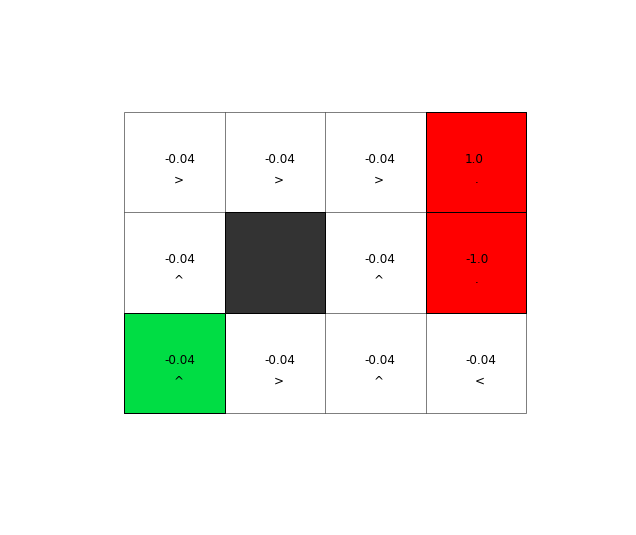

In [18]:
mdp = read_mdp("fig17.mdp")
grid = mdp.to_grid()
grid.draw()
#pi = lao_star(mdp)
pi = policy_iteration(mdp)
grid.draw_policy(pi)

Try running your algorithm on a modified version of the previous MDP. `fig_17_modified.mdp` is very similar to `fig_17.mdp`, except that the quadcopter's action set is reduced to moving right. When the quadcopter tried to move right, it will stay in it's current cell with probability 0.8, and will move right with probability 0.2. Note that this next cell will also check your solution!

States= 11 Actions= 1 Terminals 1
Checking final policy...


Tests passed!!

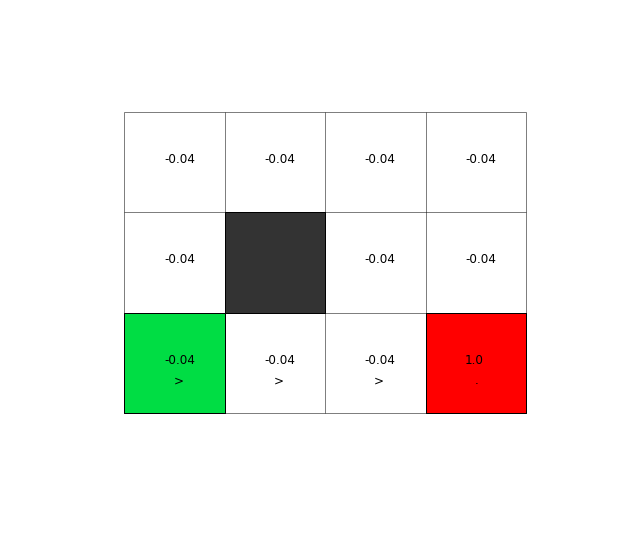

In [15]:
mdp = read_mdp("fig_17_modified.mdp")
grid = mdp.to_grid()
grid.draw()
pi = lao_star(mdp)
grid.draw_policy(pi)
check_final_solution(pi)
test_ok()

## Wrap-Up

Consider the difference between the two MDP examples provided in this PSET. What are the benefits of using LAO-star vs value iteration? When does it make sense to use LAO-star to solve an MDP?

<br/>
<div class="alert alert-info">
Please type your answer below
</div>

Notice that all the state space hasn't been expanded! This cuts down on the value iteration and policy iteration that we have to do. LAO-star therefore makes sense when to get to your goal you probably won't have have any chance of exploring the entire state space following your optimal policy. 